In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
torch.set_default_dtype(torch.float64)
device_glob = 'cuda' if torch.cuda.is_available() else 'cpu'

# MINE Ablation Study

Code is taken from MINE implementation directly and some additional changes added

In [2]:
class MineELU(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out')
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out')
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out')
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input_arg):
        output = F.elu(self.fc1(input_arg))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output
    
class MineReLU(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input_arg):
        output = F.elu(self.fc1(input_arg))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output
    
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    joint , marginal = batch
    joint = torch.from_numpy(joint).to(device)
    marginal = torch.from_numpy(marginal).to(device)
    mi_lb, t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

def sample_batch(data, batch_size, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
    return batch

def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(1e+5), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data, batch_size), sample_batch(data, batch_size, sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.item())
        if (i+1) % log_freq == 0:
            print(result[-1]) 
    result = np.asarray(result)
    return result

def ma(a, window_size=100):
    return [np.mean(a[i:(i+window_size)]) for i in range(0,len(a)-window_size)]

covariance used in all experiments is selected as 0.8 which is equal to correlation. The relationship between correlation and mutual information is the following for gaussian multivariate random variables [ref](https://lips.cs.princeton.edu/correlation-and-mutual-information/):

\begin{equation*}
    I(X, Y) = -\frac{1}{2}\ln(1 - Corr(X, Y)^2)
\end{equation*}

Therefore, the mutual information $I(X, Y) = 0.51082562376$

In [3]:
cov = [
    [1., .8],
    [.8, 1.]
]

## Sample size effects the performance of the model

**The most the sample size is the better performance results taken from the model.** For the ablation study the following sample sizes are tested with 128 as a batch size and ELU as an activation function using the given MINE model: [128, 256, 512, 1024, 2048]

In [4]:
def plot_sample_size_graphs(results, sample_size):
    plt.rcParams['figure.dpi']=300
    plt.figure(figsize=(8, 5))
    result_cor_ma = ma(results)
    plt.plot(range(len(result_cor_ma)), result_cor_ma, label='Estimations')
    plt.hlines(0.51082562376, 0, len(result_cor_ma), colors='red', label='Expected mutual information')
    plt.scatter(len(result_cor_ma), result_cor_ma[-1], c='orange', zorder=100, label='Final estimation')
    plt.annotate('{:.2f}'.format(result_cor_ma[-1]), (len(result_cor_ma), result_cor_ma[-1]), fontsize=9, zorder=200)
    z = np.polyfit(range(len(result_cor_ma)), result_cor_ma, 2)
    p = np.poly1d(z)
    plt.plot(range(len(result_cor_ma)), p(range(len(result_cor_ma))), color='orange', label='Trend line of estimations')
    plt.legend()
    plt.ylabel('Mutual information')
    plt.xlabel('# of iterations')
    plt_name = '{}.jpg'.format(sample_size)
    plt.savefig(os.path.join('./plots/sample_size', plt_name))

In [5]:
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=128)
mine_net_cor = MineELU().to(device_glob)
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.5424491217185343
0.5254314728306059
0.39742911463370995
0.6567995447631262
0.4564429864789237
0.47985446360451034
0.506476083001919
0.5174043102434052
0.502161335368119
0.4105658448065544
0.4536640405989411
0.35721911988415717
0.3787701696780176
0.39324889500112525
0.5697674156214108
0.4599474446991047
0.7360738833405305
0.5341465619304304
0.4916537097505518
0.41395755644429066
0.6269356947652218
0.47523744082498076
0.5767380944169844
0.5102849450597235
0.46540349929138625
0.6556281127875285
0.4878816142792388
0.3560955506113387
0.7017497550391806
0.6071631293754242
0.5423964775575275
0.4572236650794658
0.41346834196872545
0.39234432360525145
0.3994770528695306
0.4727156753174229
0.5515042911486603
0.6705097029932658
0.4610953443672075
0.6536713784730938
0.5466825685826424
0.709957192034209
0.6062804428490068
0.7098739249597547
0.3201329281233112
0.6489434722190717
0.7572736570229138
0.6475207515608885
0.6416248464622327
0.6260117769873423
0.7298598078446206
0.42162697565982493
0.678

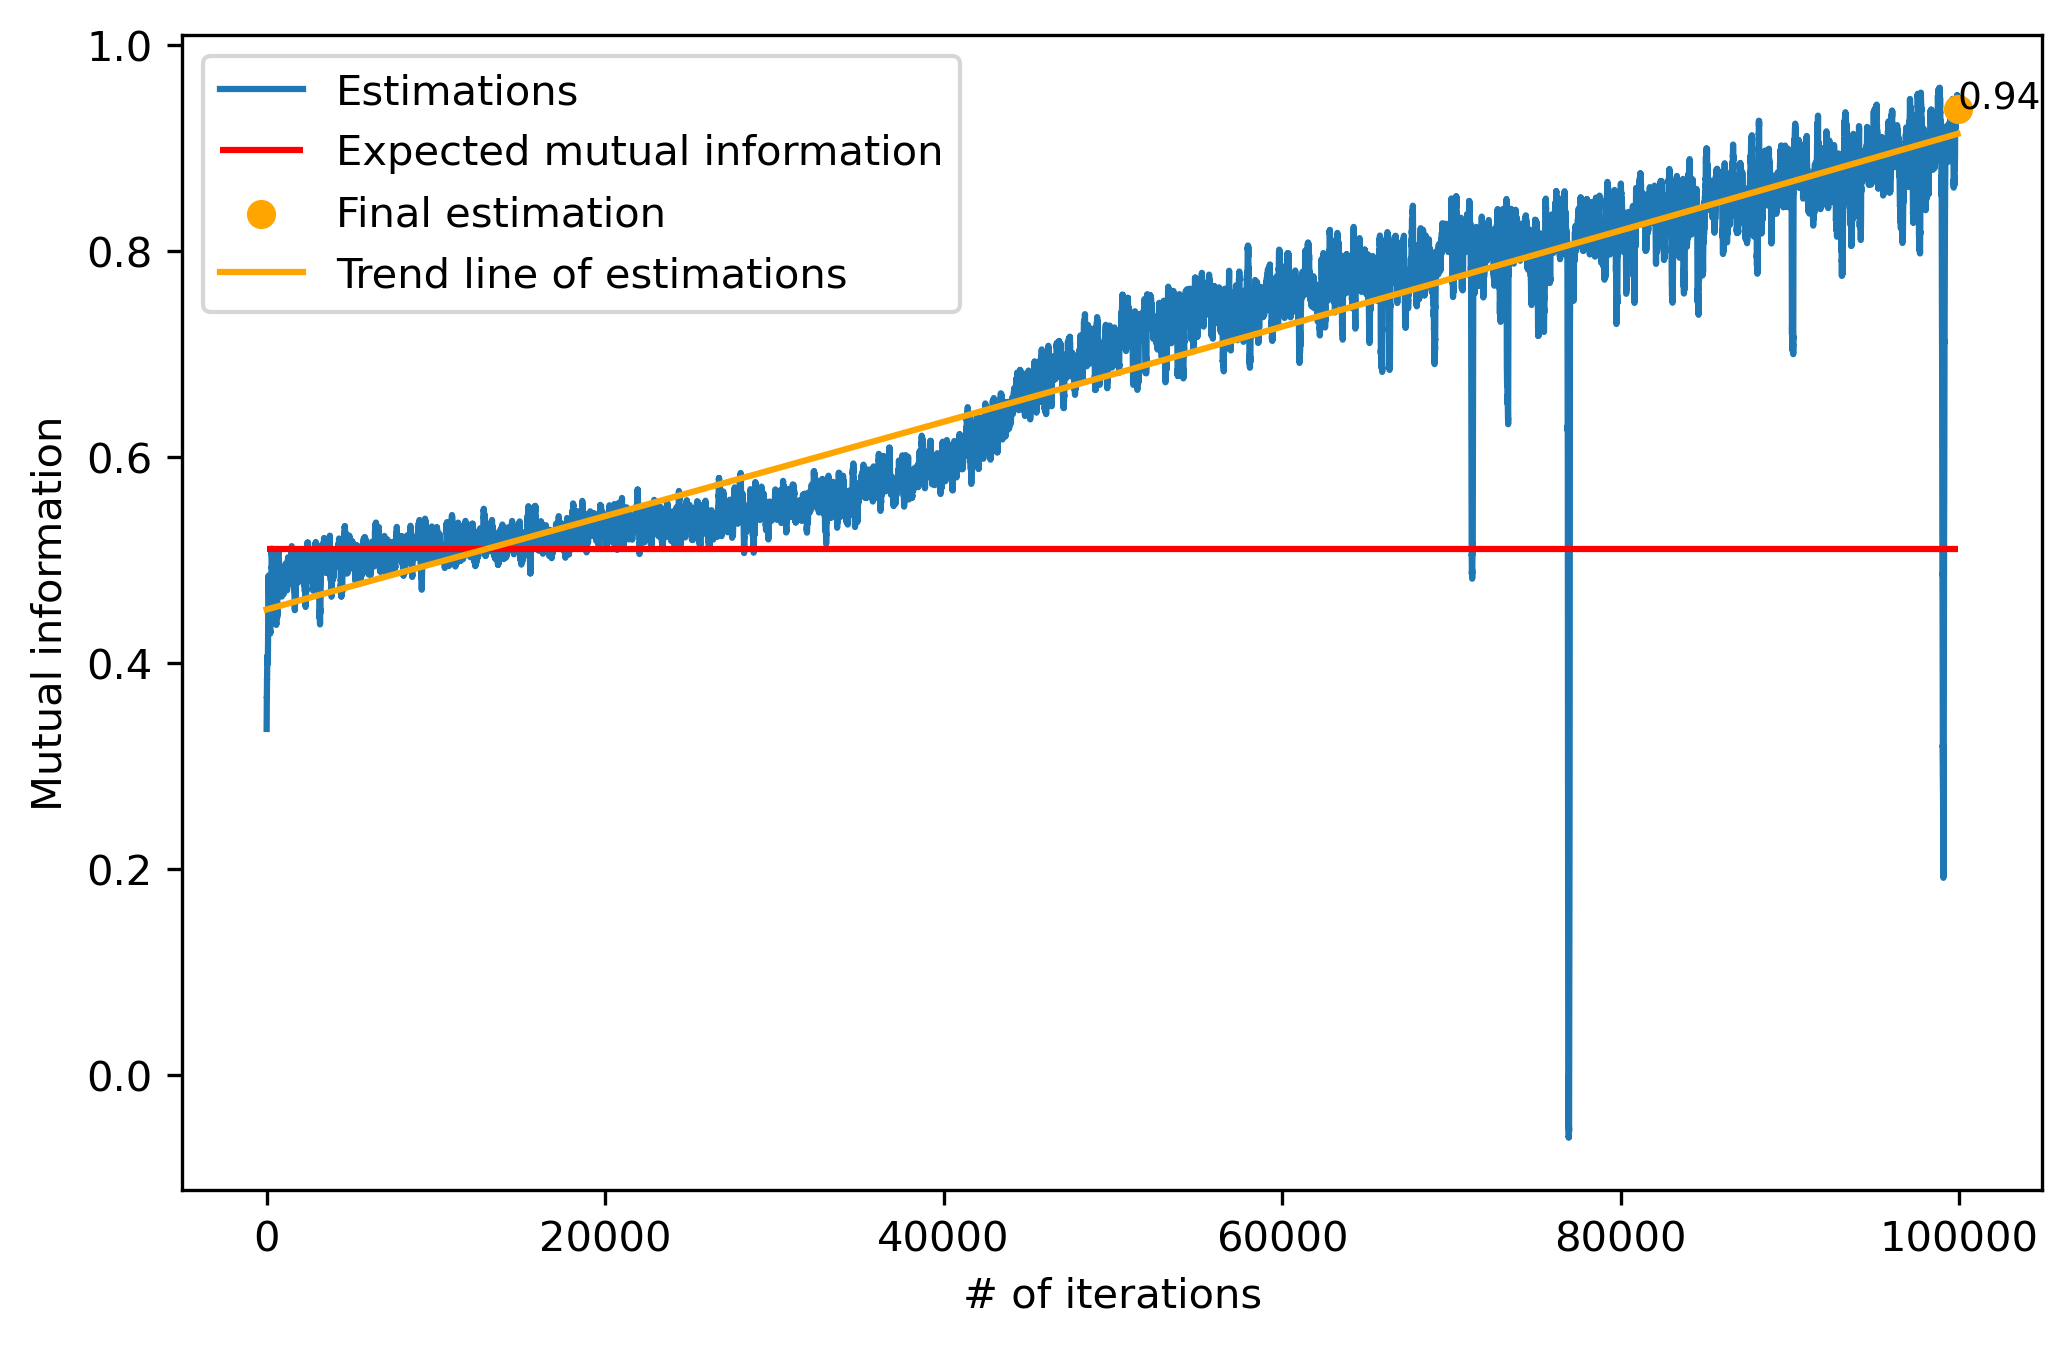

In [6]:
plot_sample_size_graphs(result_cor, 128)

In [7]:
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=256)
mine_net_cor = MineELU().to(device_glob)
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.4023388168846534
0.5975615598131415
0.3361222378045781
0.5193393914747471
0.42269098197806204
0.5752232165895246
0.602499580285585
0.5282780114131305
0.4682637650850316
-0.10471597012151201
0.487366015109045
0.588435611209075
0.5605762892984238
0.4547685400558644
0.5250083034470677
0.49898461806997313
0.37754555149889146
0.5702082311544193
0.6212493283643202
0.4131611940605917
0.49762011676650103
0.5497824409165576
0.6981957107845708
0.5223034101980337
0.6017542992825832
0.5305848364455072
0.47553314201216257
0.6580558519046374
0.001453347553685369
0.566256050036897
0.2561059630502315
0.3833582190559305
0.4520998449006659
0.6421221631659529
0.5359294174761317
0.6956169863024989
0.48955019457387605
0.41241675741769535
0.6283488421033583
0.5680649387252934
0.6089738336149589
0.43358118653186345
0.5398110435508519
0.264194878635612
0.5981280445249062
0.5402467382526438
0.4105583623724749
0.5320950051393516
0.6715766091316632
0.43698606979589716
0.5727361324010067
0.643570707243295
0.590

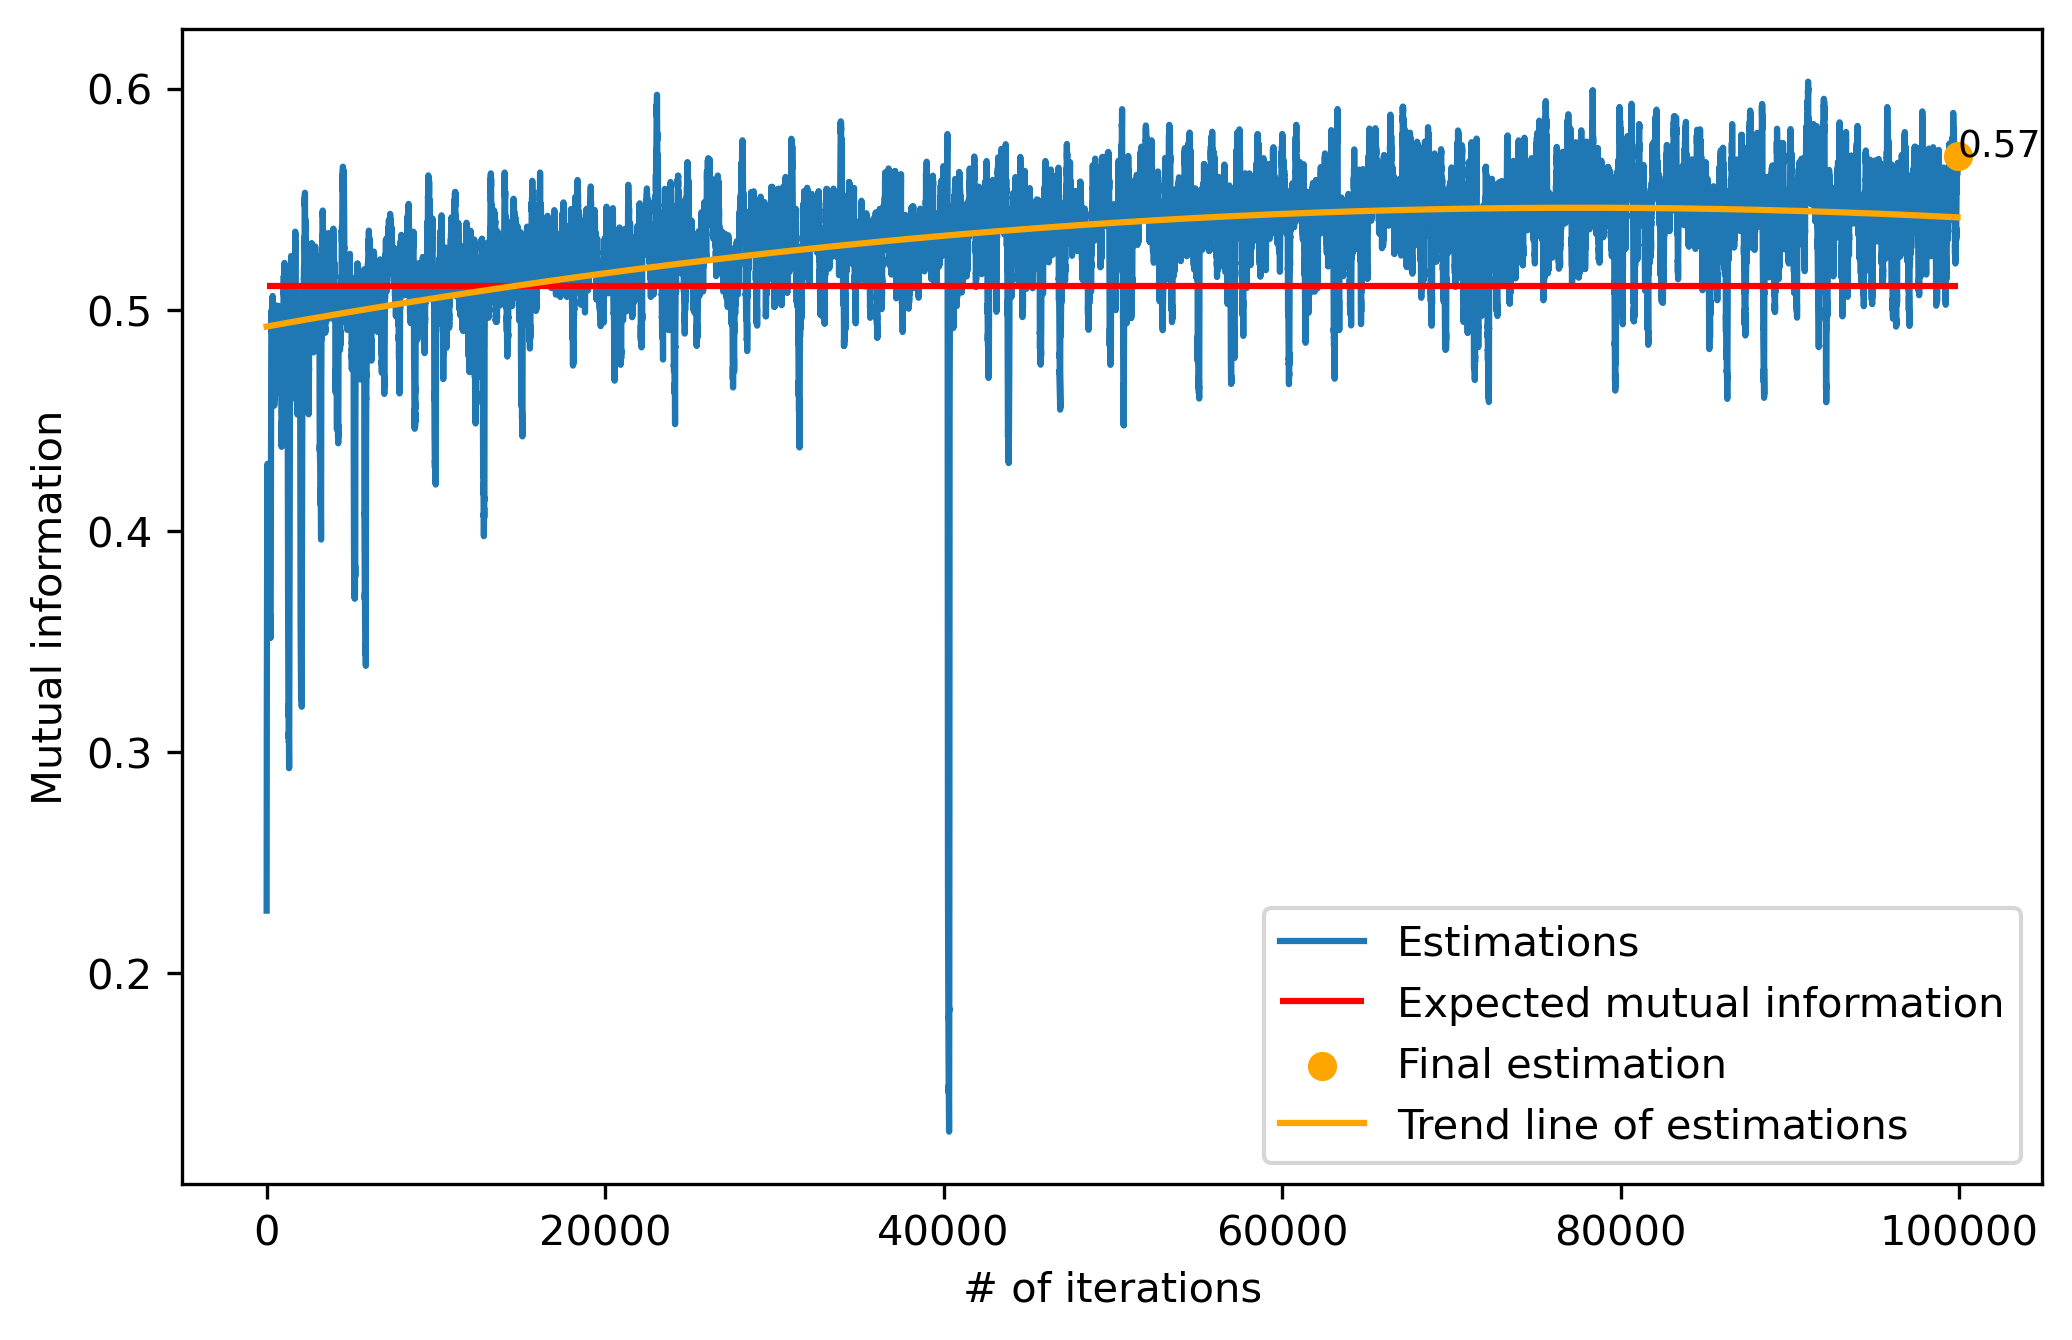

In [8]:
plot_sample_size_graphs(result_cor, 256)

In [9]:
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=512)
mine_net_cor = MineELU().to(device_glob)
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.5419608841837938
0.5624209003016583
0.435098827241588
0.699105989776099
0.5154341879099241
0.4922785789256198
0.4303839703451365
0.40064648869255254
0.6097310078259355
0.4390576777664122
0.6634144115202653
0.46149619359653166
0.5814634042468159
0.6641215983310277
0.4728618229924704
0.6212909363716764
0.43382424338320746
0.6113381083386386
0.5751748944239653
0.5284097185999782
0.516355314362128
0.4772526782816542
0.5989955794605852
0.46221647023247214
0.43506429695742077
0.4388702340626102
0.5903260179565074
0.6248715232249484
0.5464552974024103
0.2255324098868046
0.5704467679460868
0.6799036129186958
0.6288929917461717
0.3663855098367697
0.67965097063727
0.555673731898089
0.5180370704760018
0.5191592452482101
0.4837617324630349
0.4445627638092071
0.43183265017744843
0.453086148170495
0.4635303683497095
0.6384091602251699
0.45723073811028003
0.49573594070903115
0.5817841782815216
0.5082134646557847
0.44365741206186676
0.44361589519121636
0.5142394147300033
0.48024928781906756
0.670417

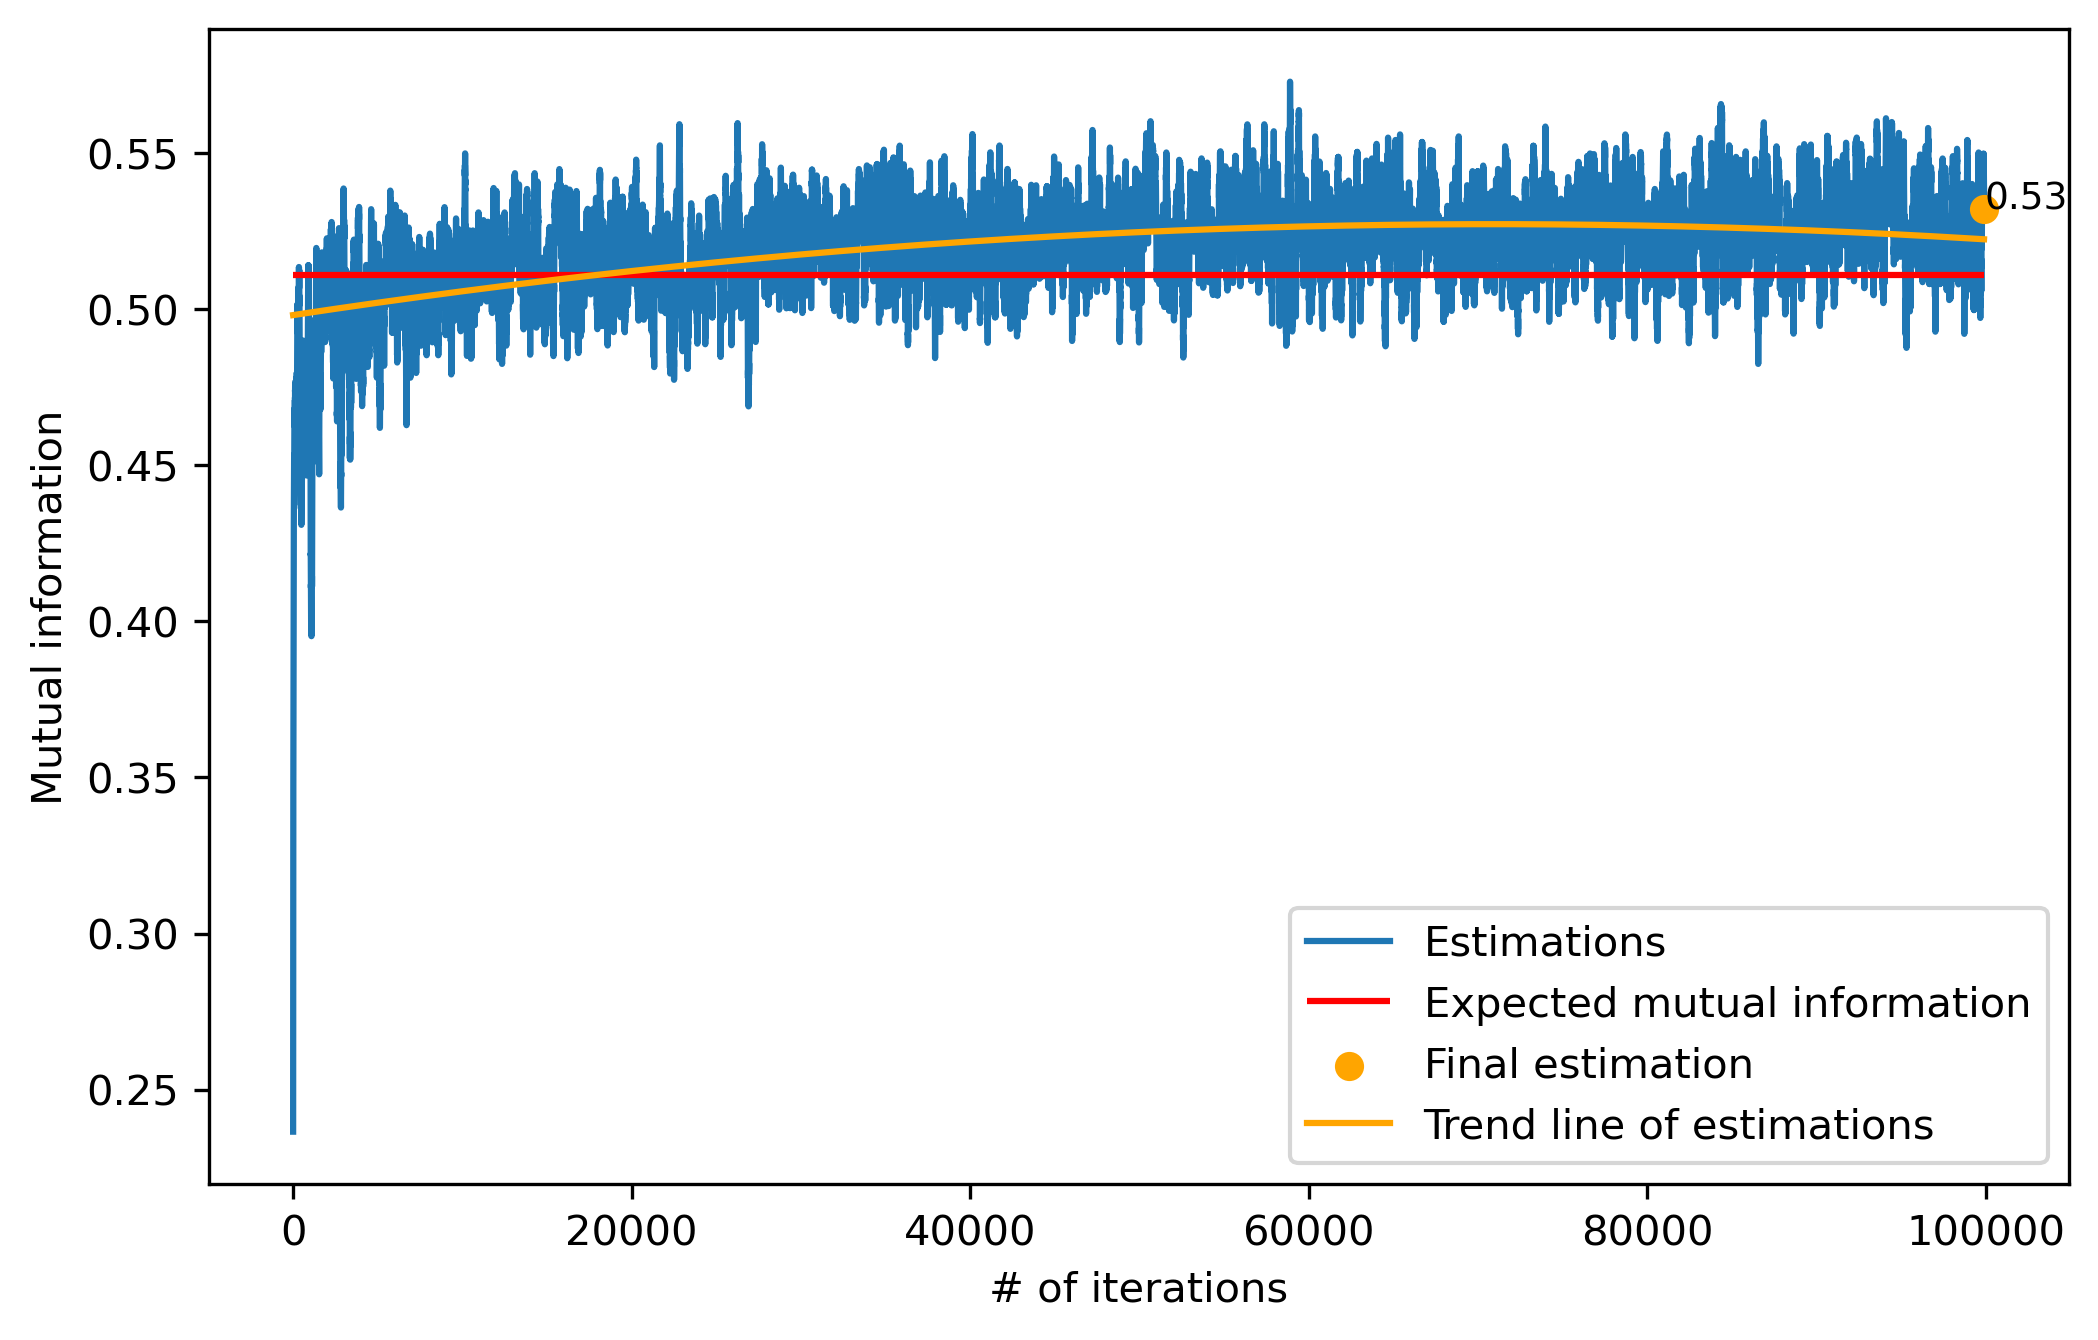

In [10]:
plot_sample_size_graphs(result_cor, 512)

In [11]:
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=1024)
mine_net_cor = MineELU().to(device_glob)
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.48958009880636855
0.6462997634733654
0.6274542668624901
0.3484379542446354
0.5556518367638077
0.38946781275775466
0.31598396333676293
0.5335503098451282
0.35702725231307975
0.5104507108521164
0.49194434706992984
0.2666437739840868
0.3365602591932979
0.4603255278821221
0.35135895607946876
0.4425379757897838
0.5587062195706514
0.5060894101608584
0.5348509263935259
0.3152742416277894
0.5429719479108752
0.6116609794308645
0.5452383083543193
0.4082643099010319
0.44836020544370525
0.5955826045101156
0.5447082758816122
0.46833089652569004
0.6106991377107129
0.5320450431395973
0.45445249223612905
0.1562848388037481
0.37713247093634195
0.5182680895461869
0.3989960847292622
0.7097517212979918
0.5806365534782896
0.6371051310696298
0.38278907442063126
0.6444760697937446
0.4032285431966267
0.5821113165394167
0.43771536709196335
0.1470721733517757
0.82511394963994
0.28623011277263144
0.4203467946009116
0.4952637869593648
0.5417012681409616
0.8191266546484619
0.3580088873377756
0.4917434485766887
0

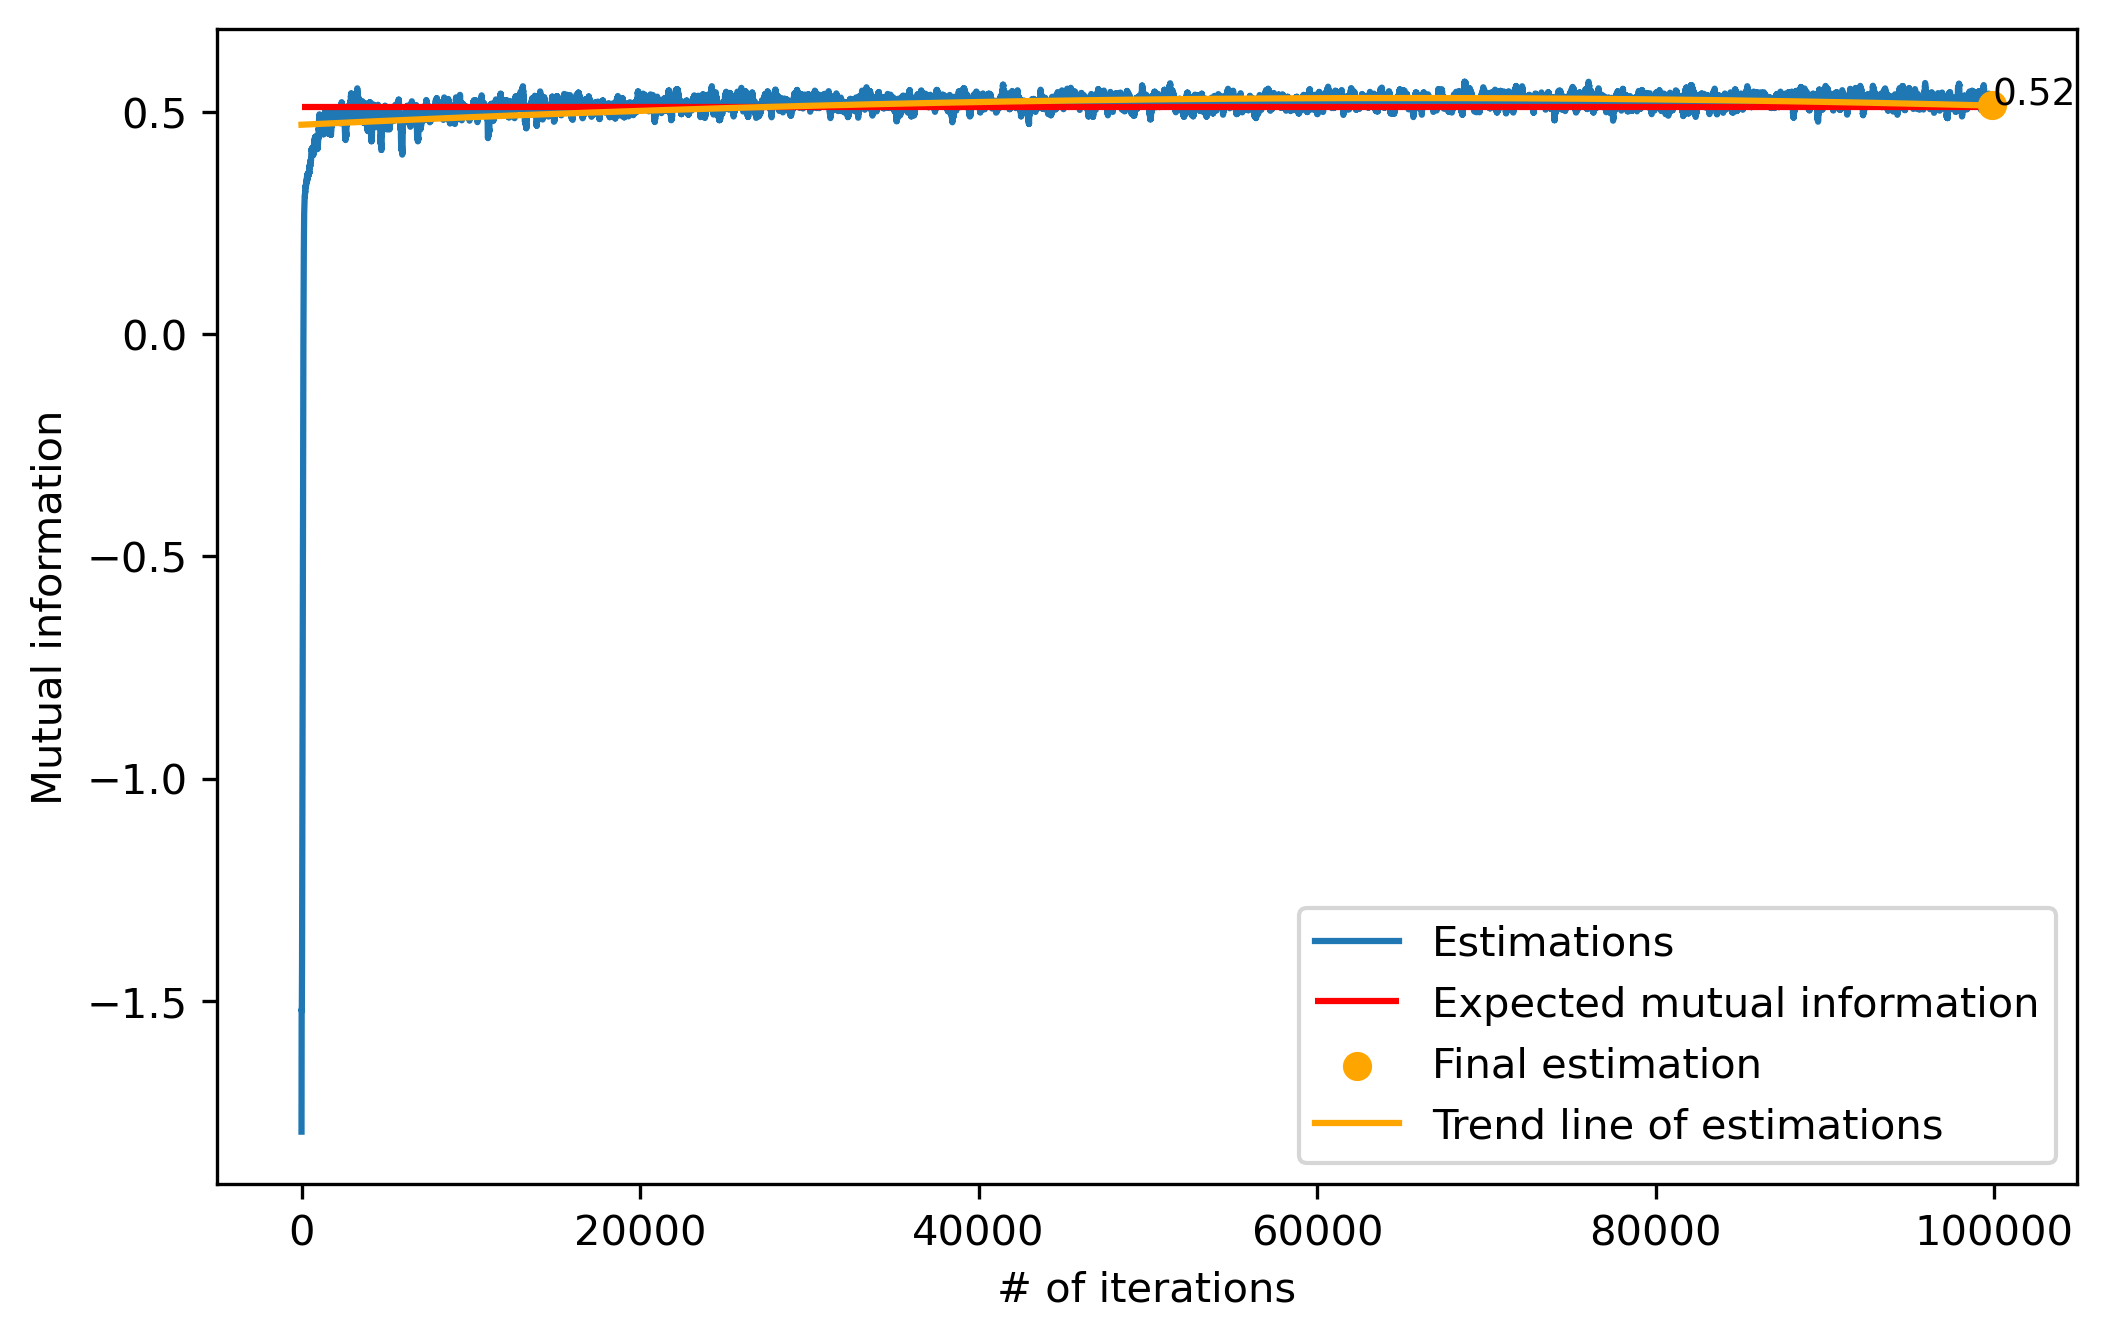

In [12]:
plot_sample_size_graphs(result_cor, 1024)

In [15]:
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=2048)
mine_net_cor = MineELU().to(device_glob)
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.4942599600023291
0.3312595395902632
0.37657025110777076
0.639237579966295
0.44292414129919694
0.4499088394717499
0.48309519145554175
0.3491481548829296
0.6129138930288553
0.5846476857508653
0.2415725522036245
0.38602677370946237
0.7452214529697916
0.4970930012599709
0.65632369855787
0.5218918748303348
0.4250693581256191
0.5292354974699439
0.46477066068147876
0.33695904694426193
0.35648951910133453
0.6453173330593646
0.4434694603620585
0.4990846264570834
0.4713133628255741
0.5518735783449238
0.5318593838245391
0.4642288338694822
0.4413236606553419
0.8279824973427826
0.4995041977395998
0.711295050034316
0.3577228632568721
0.43893681112872873
0.320846641770432
0.4378838638823157
0.22875991183800695
0.5965278098888073
0.6098261775731488
0.5325033948418908
0.5168990154327008
0.28410657373338544
0.4120249288198219
0.5748780954994075
0.3043927858548009
0.6793808562070697
0.627345363784245
0.5602125840823093
0.3011464894150633
0.29957108147587785
0.4928590111256802
0.5264971929934957
0.67518

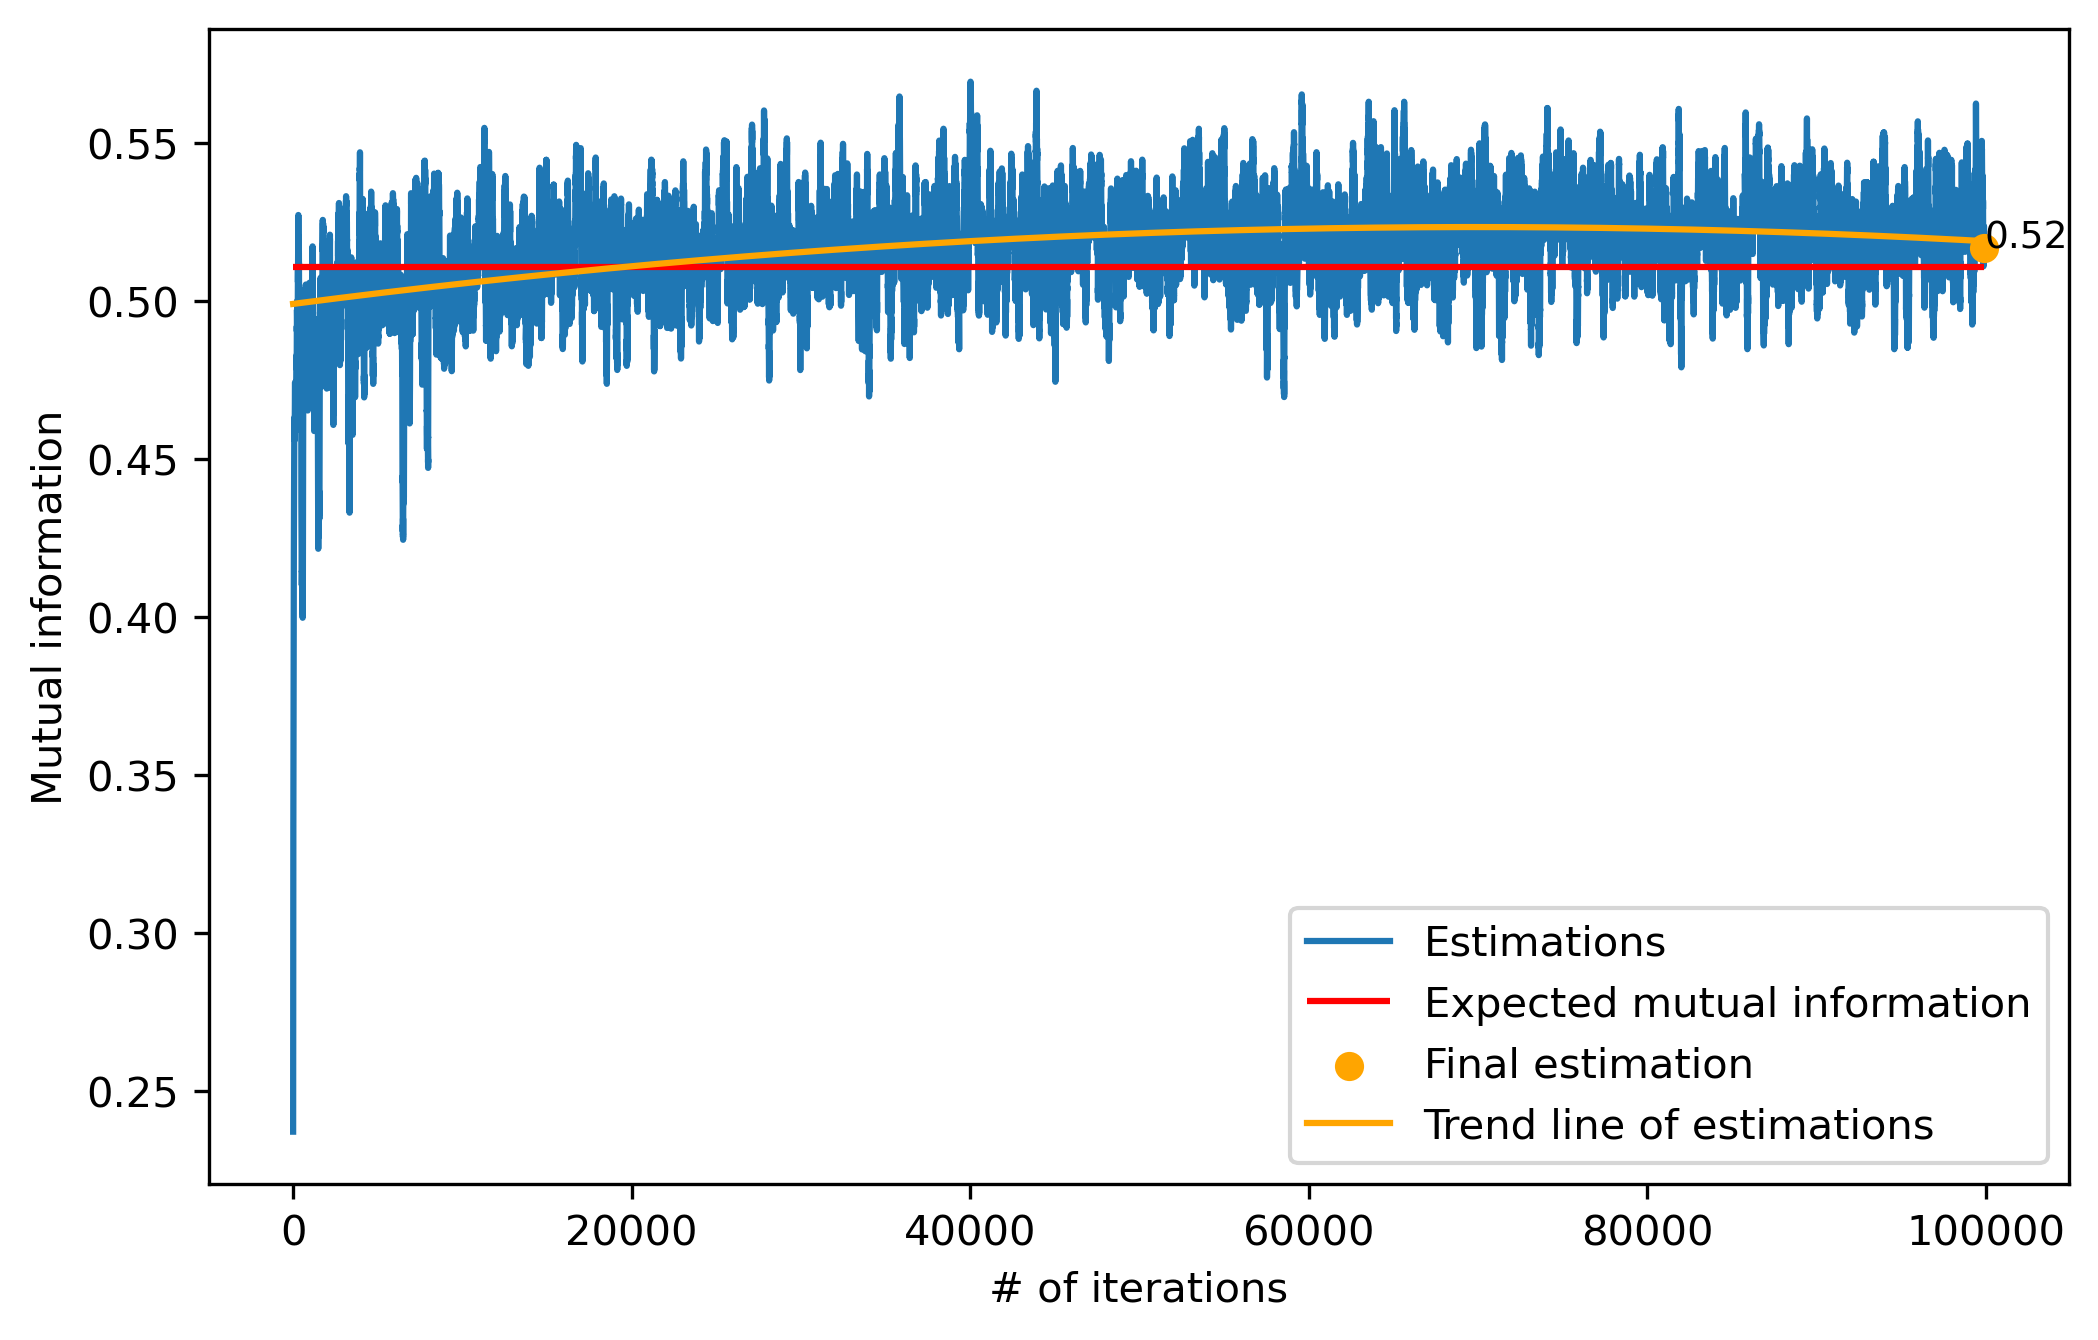

In [16]:
plot_sample_size_graphs(result_cor, 2048)

## Constant scaling does not affect the result if the constant is not big



In [18]:
def plot_data_scale_graphs(results, name):
    plt.rcParams['figure.dpi']=300
    plt.figure(figsize=(8, 5))
    result_cor_ma = ma(results)
    plt.plot(range(len(result_cor_ma)), result_cor_ma, label='Estimations')
    plt.hlines(0.51082562376, 0, len(result_cor_ma), colors='red', label='Expected mutual information')
    plt.scatter(len(result_cor_ma), result_cor_ma[-1], c='orange', zorder=100, label='Final estimation')
    plt.annotate('{:.2f}'.format(result_cor_ma[-1]), (len(result_cor_ma), result_cor_ma[-1]), fontsize=9, zorder=200)
    z = np.polyfit(range(len(result_cor_ma)), result_cor_ma, 2)
    p = np.poly1d(z)
    plt.plot(range(len(result_cor_ma)), p(range(len(result_cor_ma))), color='orange', label='Trend line of estimations')
    plt.legend()
    plt.ylabel('Mutual information')
    plt.xlabel('# of iterations')
    plt_name = '{}.jpg'.format(name)
    plt.savefig(os.path.join('./plots/data_scale', plt_name))

In [17]:
data_X = np.random.multivariate_normal(mean=[100, 100], cov=cov, size=2048)
mine_net_cor = MineELU().to(device_glob)
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

-0.022556752427721705
-0.11607823259090821
-0.3779329233135229
-0.41508159798429745
-0.5077596618456539
-0.4012504039096285
-0.737355047013267
-0.2681282022094251
-0.25604293464056127
-0.010462343331582247
-0.33502962863641983
-0.3130151053297823
-0.3093275181254427
-0.3475133812613649
-0.1616395424391044
-0.28471374962555274
-0.42504605279509633
-0.4488275791183298
-0.42606248843239314
-0.5696954634015583
-0.7806239027689514
-0.10089960413908727
-0.6852955478915135
-0.8090817859410322
-0.3505460815127037
-0.7798384373633951
-0.7312583982813123
-0.1658532174651981
-0.43426513530934585
-0.32670513922124655
-0.8616406509169678
-0.4313595601583984
-0.3121960210430643
-0.49235676693004393
-0.745180084739502
-0.5955521382194036
-0.8461360794284474
-0.4075237147569908
-0.6465001192981674
-0.5551740231929614
-0.6794347861867607
-0.858407919744991
0.08493682738853181
-0.13448259183448386
-0.707645238471514
-1.2224797939825294
-0.6964911071955839
-0.8731420475296545
-1.0586396546816559
-0.72800

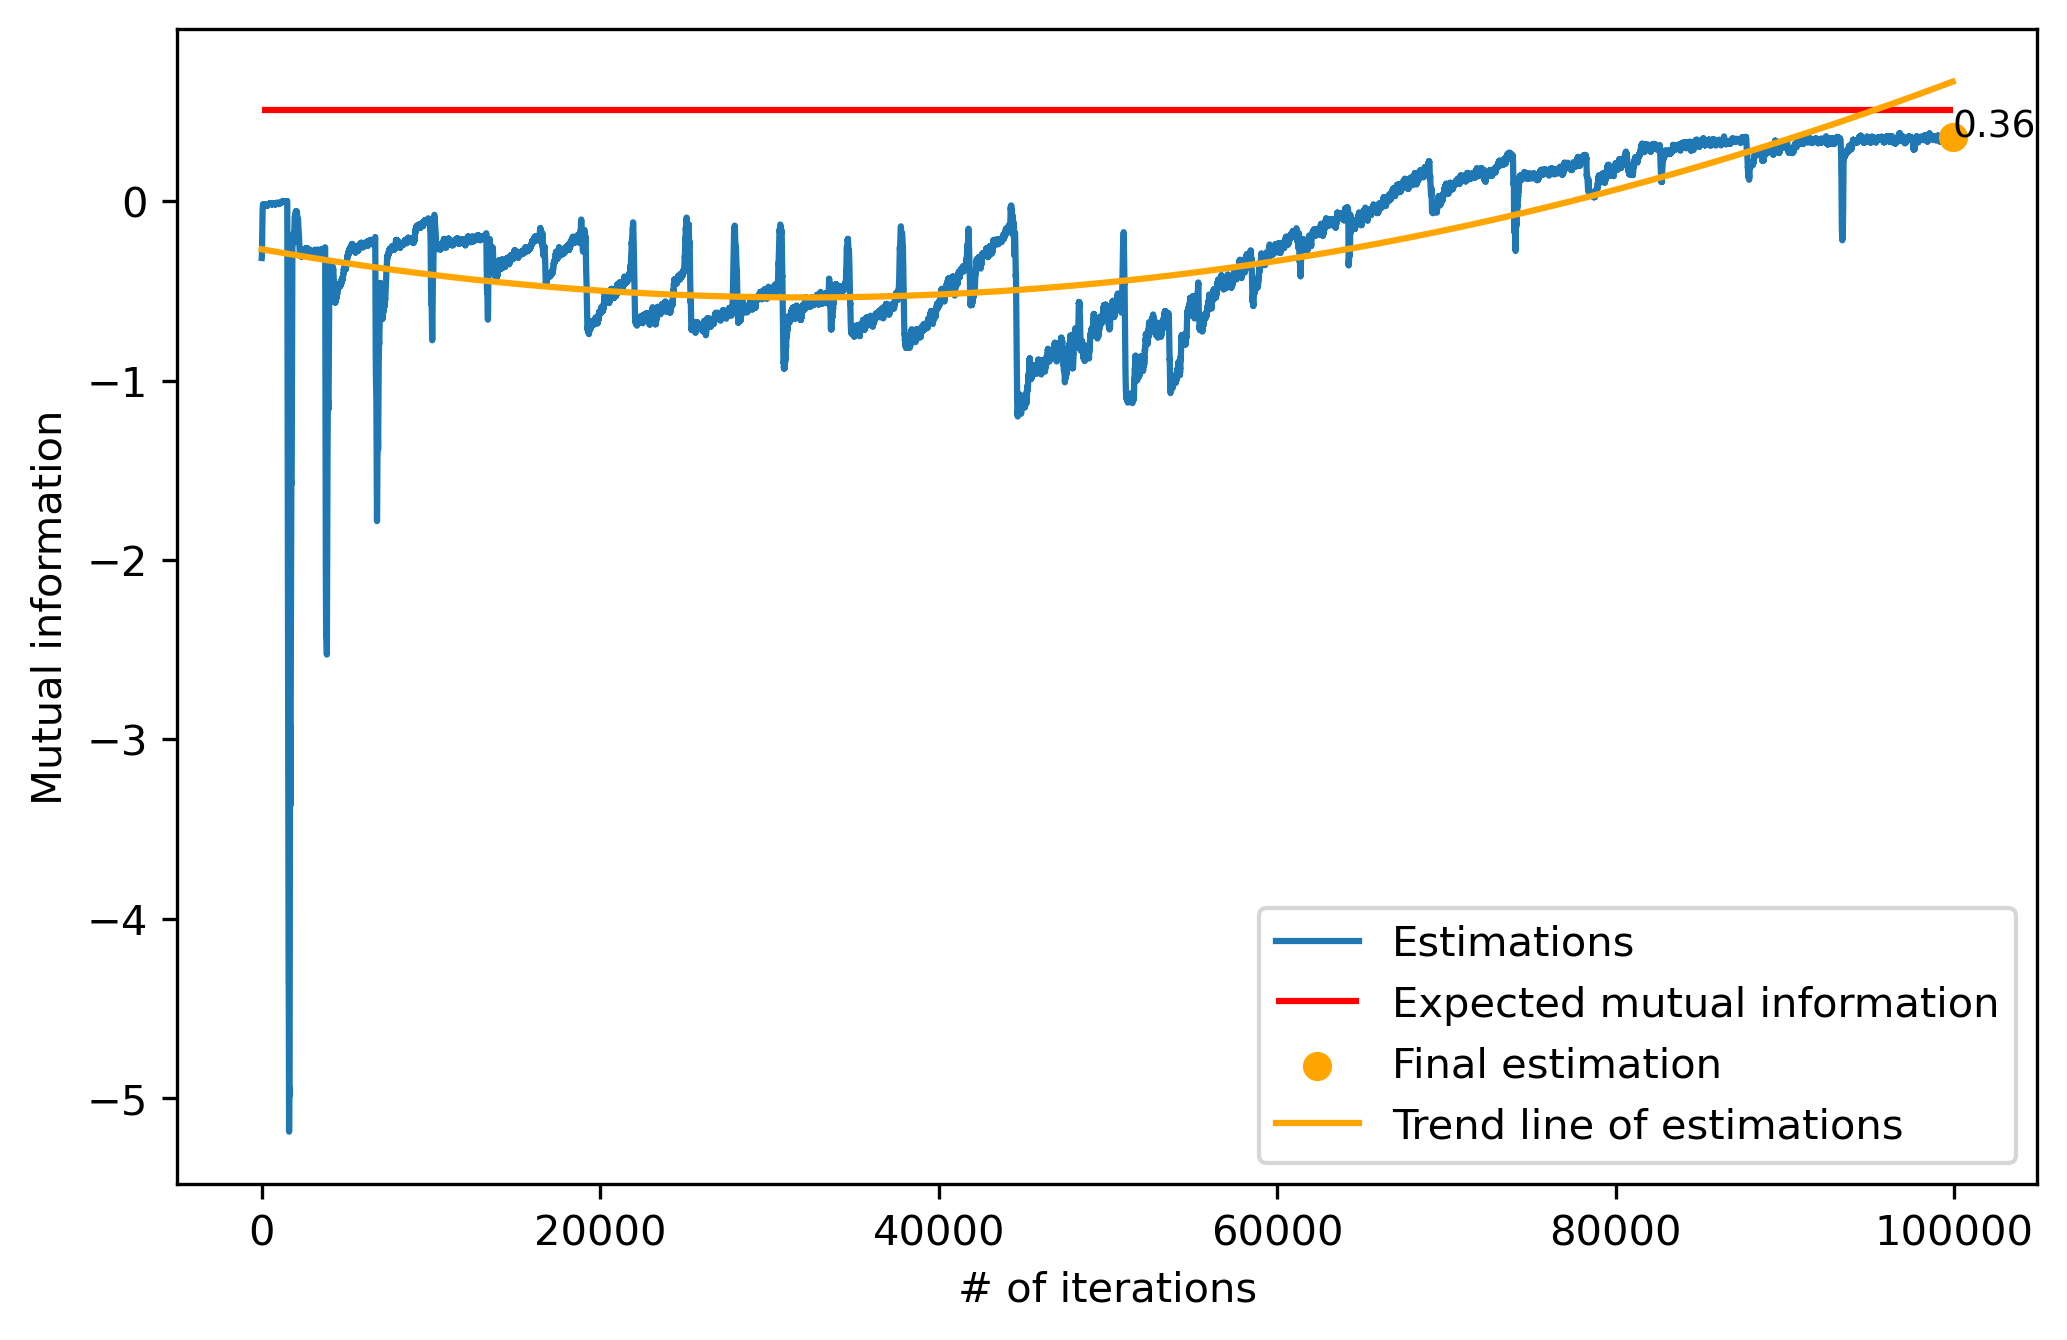

In [19]:
plot_data_scale_graphs(result_cor, 'mean_from_0_to_100')

In [22]:
data_X = np.random.multivariate_normal(mean=[100, 100], cov=[
    [100, 80],
    [80, 100]
], size=2048)
mine_net_cor = MineELU().to(device_glob)
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

-2.705489893052551
-32.02715797395048
-8.690412387232676
-7.552924705250234
-0.014586606579598538
0.41406411040799185
0.4323854494031707
0.285547994897172
0.4411206030834478
0.4707285538179349
0.4226631209994025
0.4679372591235733
0.5683924377726157
0.4799607417422749
0.48970220006145837
0.45985924219803564
0.12309108484669196
0.5978277101400522
0.3728207892010005
0.36064632102772975
-0.6002743921803244
0.48974145774559474
0.5226295879665486
0.5026636651197123
-10.501330558485506
-0.5377276337874264
0.24321577327248178
0.4118387660284384
0.4599057851189059
0.49471755469159007
0.4354211491278761
0.5354924826215779
0.7757908576559771
0.7499844439475964
0.4264658720609873
0.5062035772683089
0.22713918454746818
0.5385686235851495
0.7556982927102354
0.5023621392499535
0.47718742625295363
0.652220221512323
0.03633505904485901
0.5934036723338068
0.49312333068098724
0.39445038795497567
0.48839468020395316
0.6448201611624995
-4.0822743705085145
0.4119399170056681
0.4834039290368537
0.3827182317

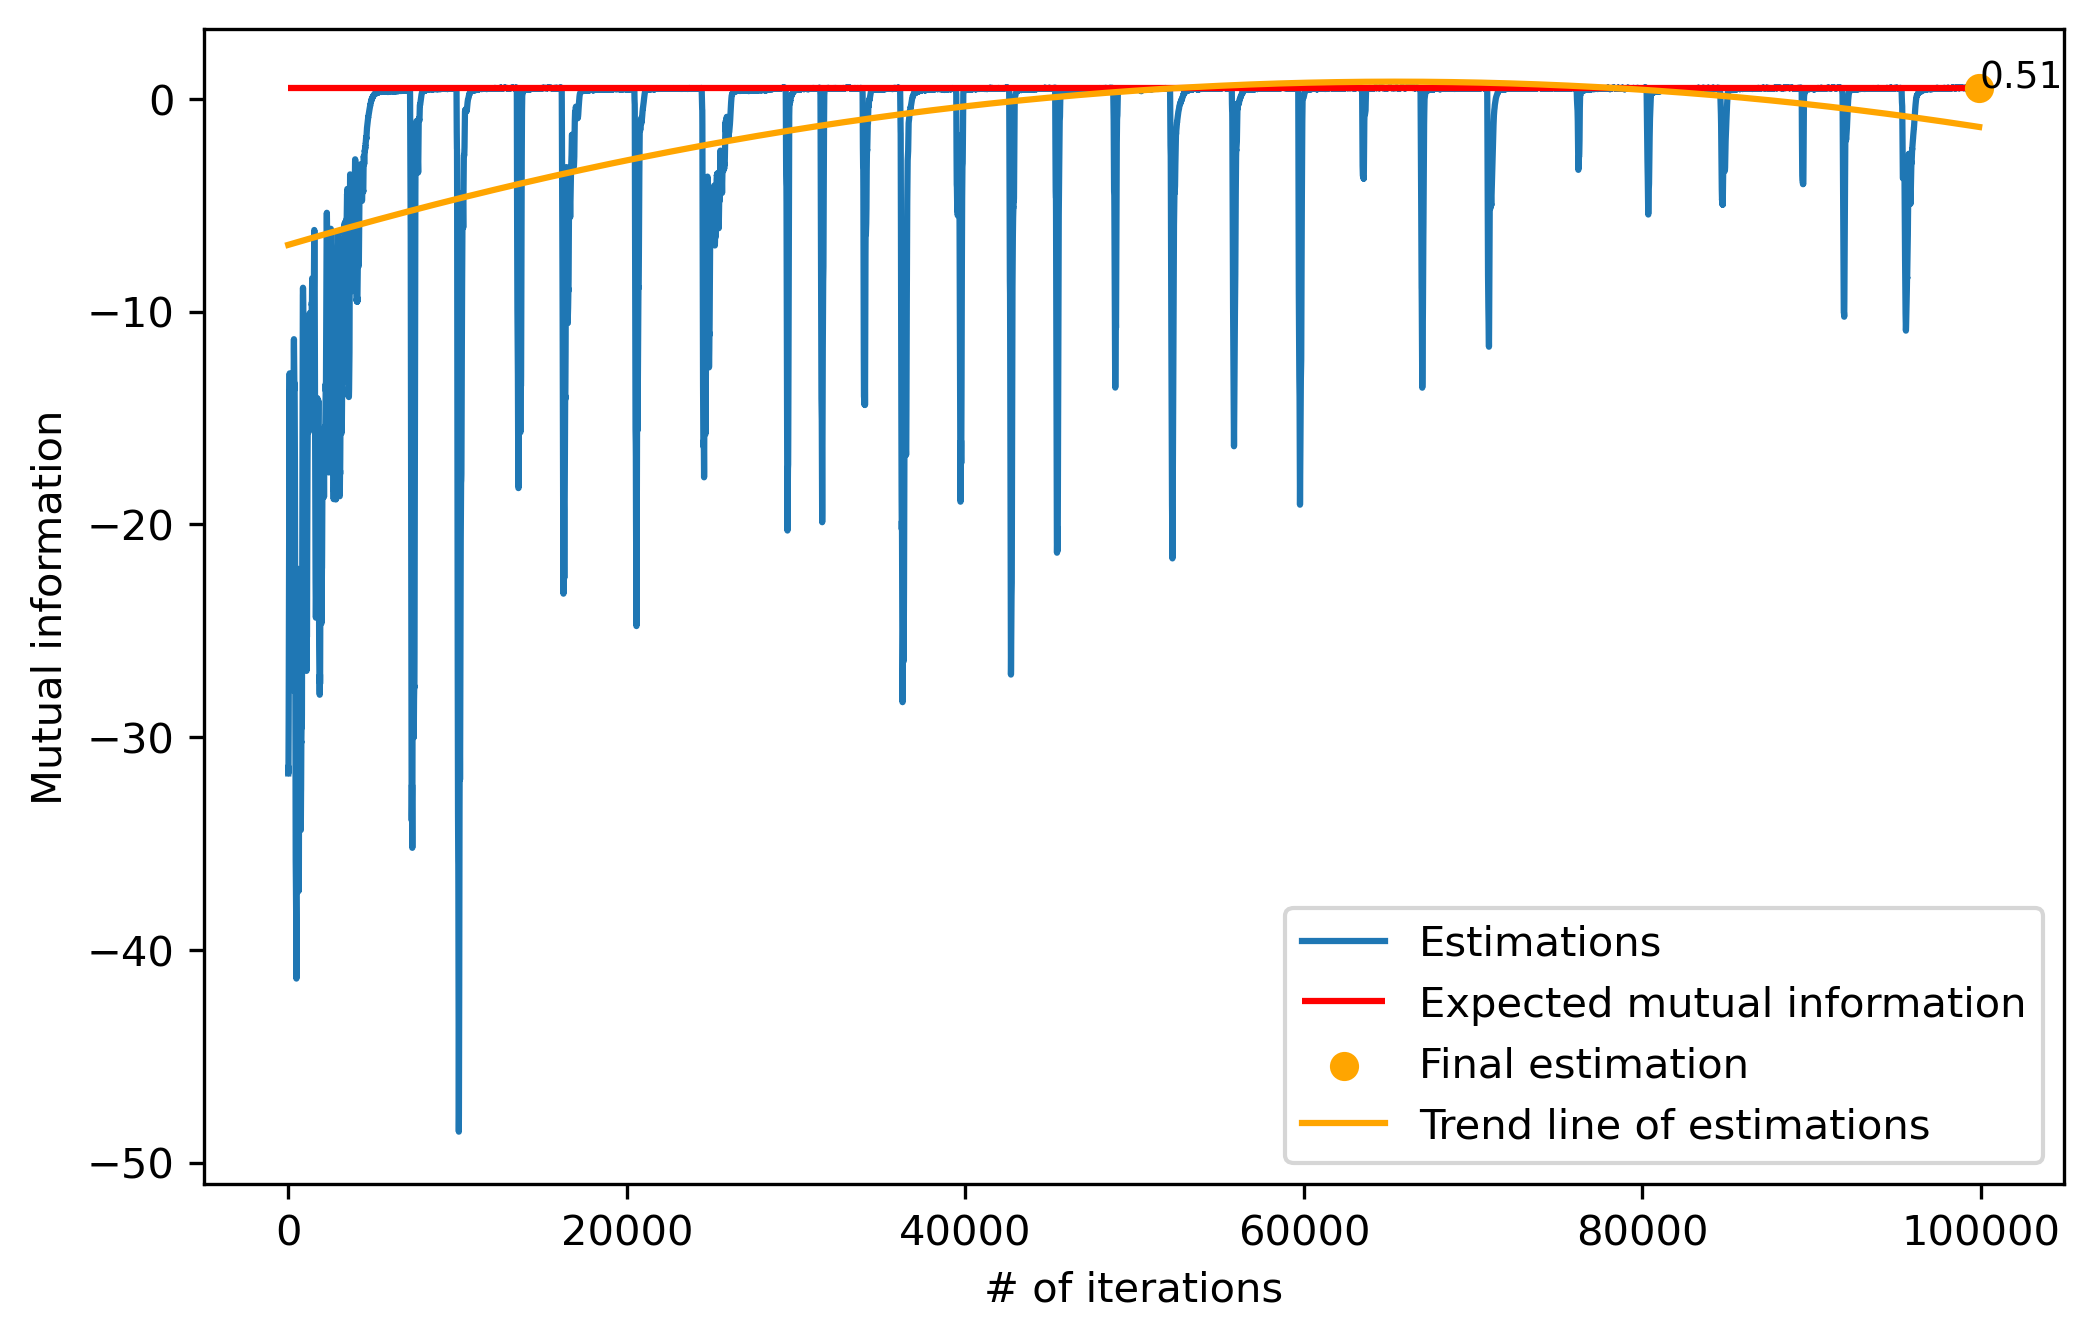

In [23]:
plot_data_scale_graphs(result_cor, 'mean_100_var_100_covar_80')

In [24]:
data_X = np.random.multivariate_normal(mean=[100, 100], cov=[
    [100, 80],
    [80, 100]
], size=2048)
mine_net_cor = MineELU().to(device_glob)
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X / 200, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.00439884339901648
0.07143606777593992
0.399372372506291
0.38860577190902756
0.13107361391968478
0.39522571175015997
0.430674661647213
0.514611598128752
0.5606421750139655
0.5455952572551791
0.3222697590922132
0.4320048550287322
0.6393022690701032
0.6526806553820106
0.6023867152962
0.6476866685033471
0.2762849711561256
0.4494561545244671
0.4991144185486472
0.34174825569398287
0.40566537668841796
0.6016633779801928
0.5857295642103
0.562297919454383
0.6425930235227832
0.4339107921114082
0.5251118564432415
0.4981767459163194
0.3909995336562382
0.5895457082079258
0.5733065505415886
0.3516216361544112
0.4711708778208046
0.5810209995503146
0.6393343144868853
0.5801707437430578
0.581318358583409
0.4285432865469181
0.5479821885832811
0.5170839931761393
0.47116378234364625
0.31572585885843274
0.36674777334674347
0.5287352724589085
0.5627840250582566
0.5639675085550067
0.7641471380205264
0.31353653591281694
0.34651706557466455
0.4498643668228268
0.2671158711184921
0.41496133018028825
0.49853404

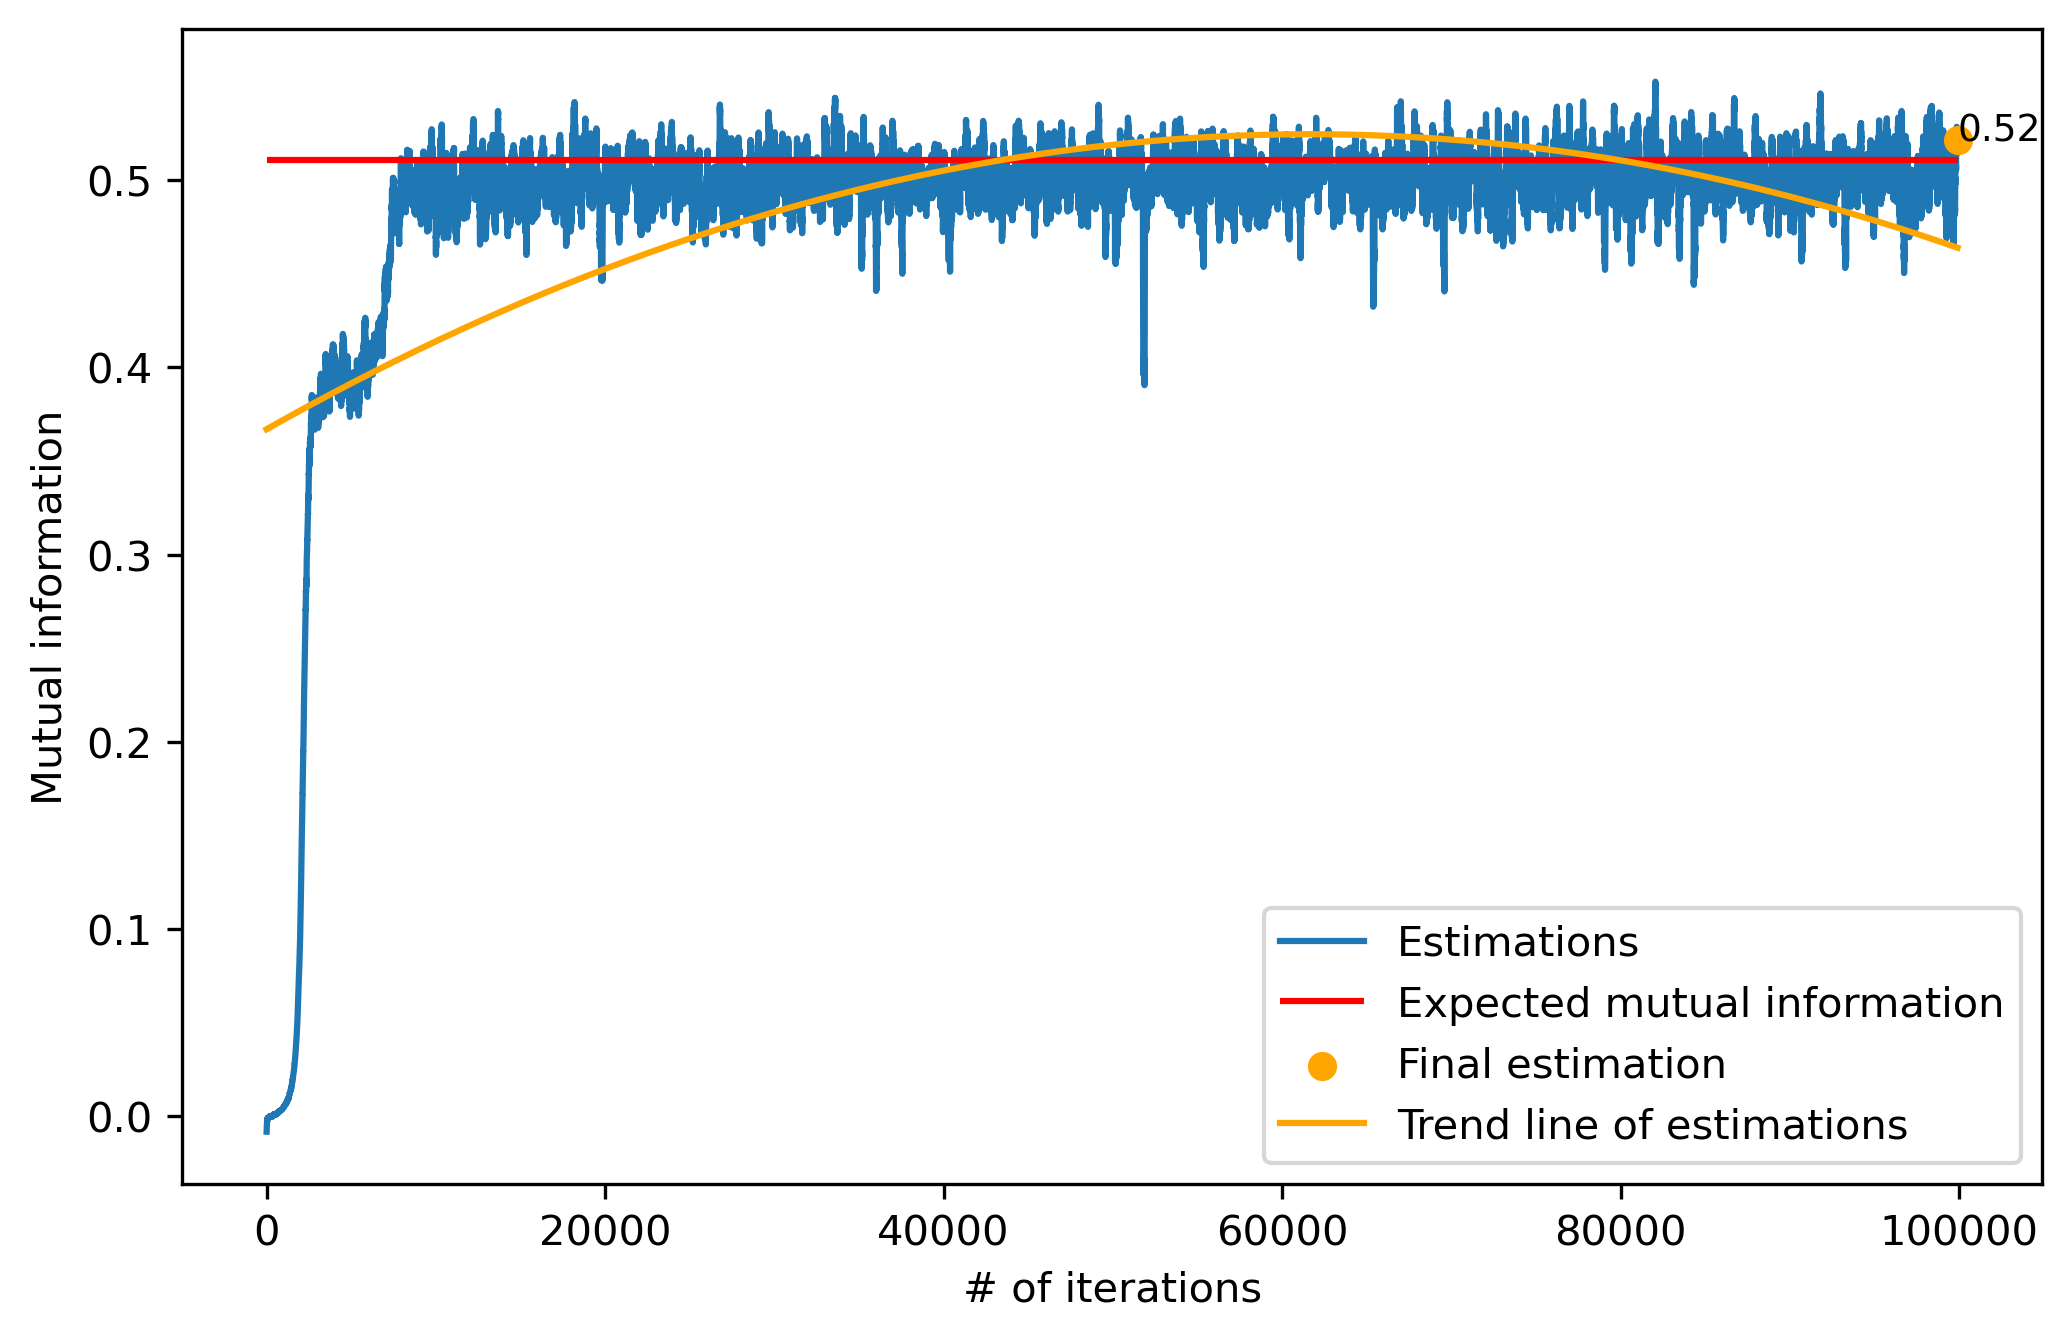

In [25]:
plot_data_scale_graphs(result_cor, 'mean_100_var_100_covar_80_scaled_200')

In [26]:
data_X = np.random.multivariate_normal(mean=[100, 100], cov=[
    [100, 80],
    [80, 100]
], size=2048)
mine_net_cor = MineELU().to(device_glob)
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X / 400, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.004783537572419371
0.21026637939033924
0.37985840017053396
0.37048408712688724
0.2745918532657979
0.41932277446957356
0.27810154874312143
0.5313635434805078
0.4258602443088173
0.5270722622501974
0.4939691017410617
0.5354617421124587
0.4173452550959161
0.44023787902150513
0.343872971115782
0.502369702021966
0.37571597447925464
0.4702797886322185
0.6761781021948466
0.18781481326653196
0.47676755106163526
0.5222441167092858
0.3240832596984412
0.5530340448174601
0.4283943415989663
0.6147342612633725
0.32885065939493247
0.3938123484673268
0.6864524256594434
0.6663846364365978
0.36339589317100396
0.352049498815086
0.5724986127304992
0.6247213281025528
0.48075157415165026
0.4426761226969617
0.5964247534852998
0.47046649237031934
0.564371044323553
0.605243406915311
0.5488693604914724
0.364250201780637
0.5153743655994129
0.5651462654917772
0.3913670873435288
0.7268454728844244
0.38912916768971223
0.5091658939857822
0.3896174872802825
0.6086242789679591
0.6796182412098299
0.4891636866100182
0.

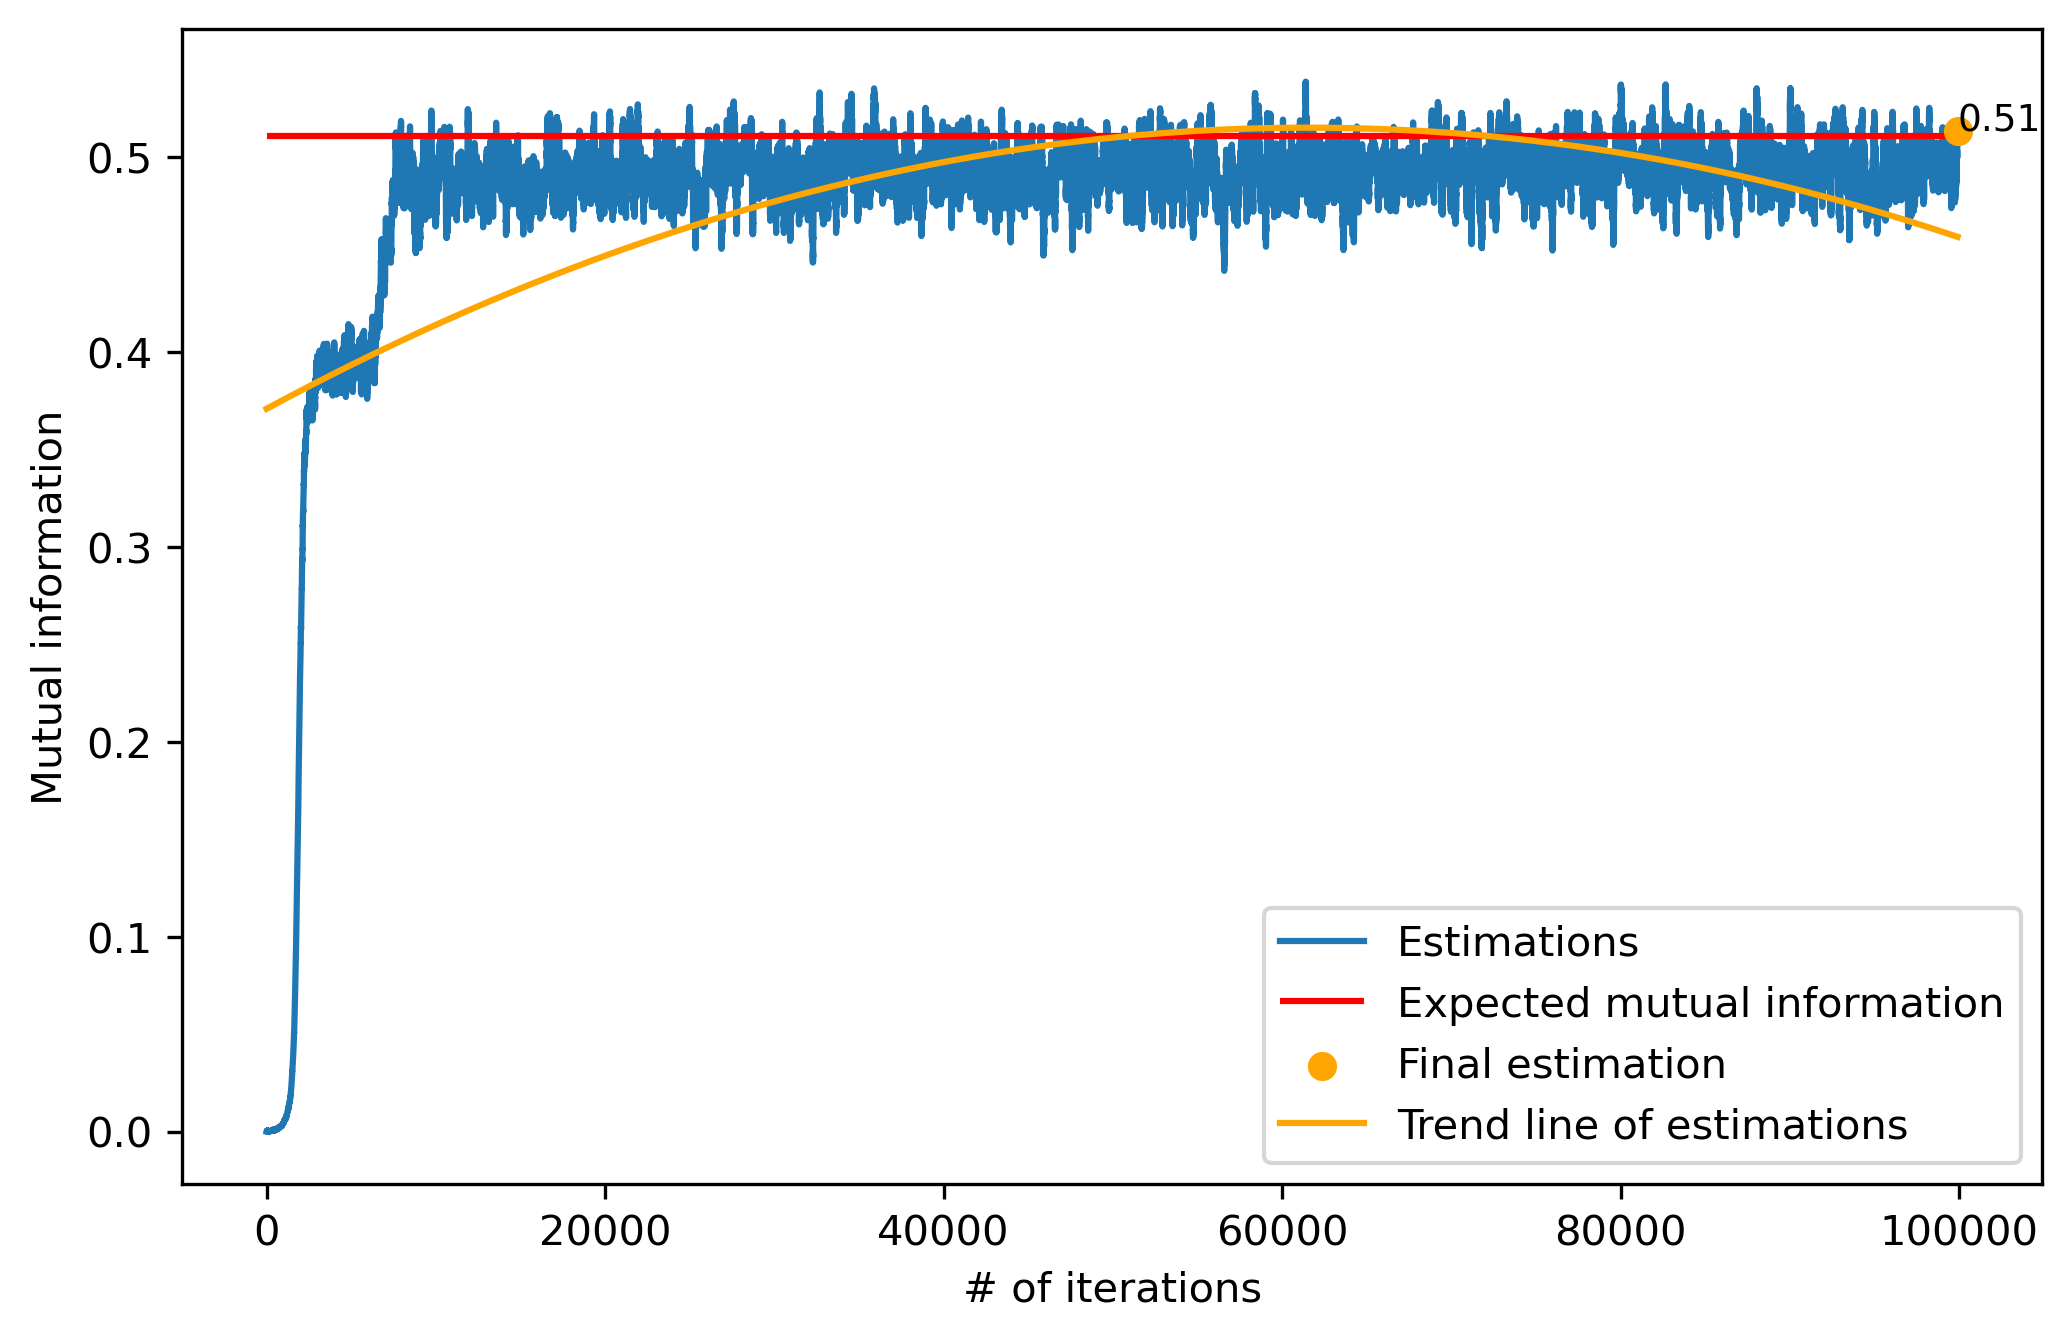

In [27]:
plot_data_scale_graphs(result_cor, 'mean_100_var_100_covar_80_scaled_400')

In [28]:
data_X = np.random.multivariate_normal(mean=[100, 100], cov=[
    [100, 80],
    [80, 100]
], size=2048)
mine_net_cor = MineELU().to(device_glob)
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X * 2, mine_net_cor, mine_net_optim_cor, batch_size=128)

-30.896349064788936
-0.071849892661632
0.3109185914693029
-39.83304541225331
0.4832501086092691
0.4036461907931397
-4.126639000295171
0.5076494395268298
0.6703972797963331
-2.928797618059548
0.4088468157622174
0.3883347721879886
-19.40743738876965
-6.345992527075225
0.23714553521983817
0.4882656182052756
0.3086804090844453
0.38288953020730787
-24.60930422521684
-1.8781671782407443
0.5016817452266764
0.3208874531875381
-0.7087967036194414
0.3624098328780292
-11.768994714303517
0.17822699166237044
0.4131176619252983
0.26788115024515946
0.452755477389303
0.41999890652982685
0.5344554600629863
0.5782160144233899
0.4207485297878293
0.6493205766933556
-14.394479058846457
-0.2609400048124826
0.3237803923686329
0.38264396156375824
0.6059025385713994
0.38357796493352225
0.5518309067813334
0.49123084785600213
-0.04551348653308196
0.5341748928022412
0.43214817822877194
-0.815747184452789
0.3972306521372957
0.4676231377174531
-7.917138032988362
0.607087249990343
0.6085502948140515
0.57976679705592

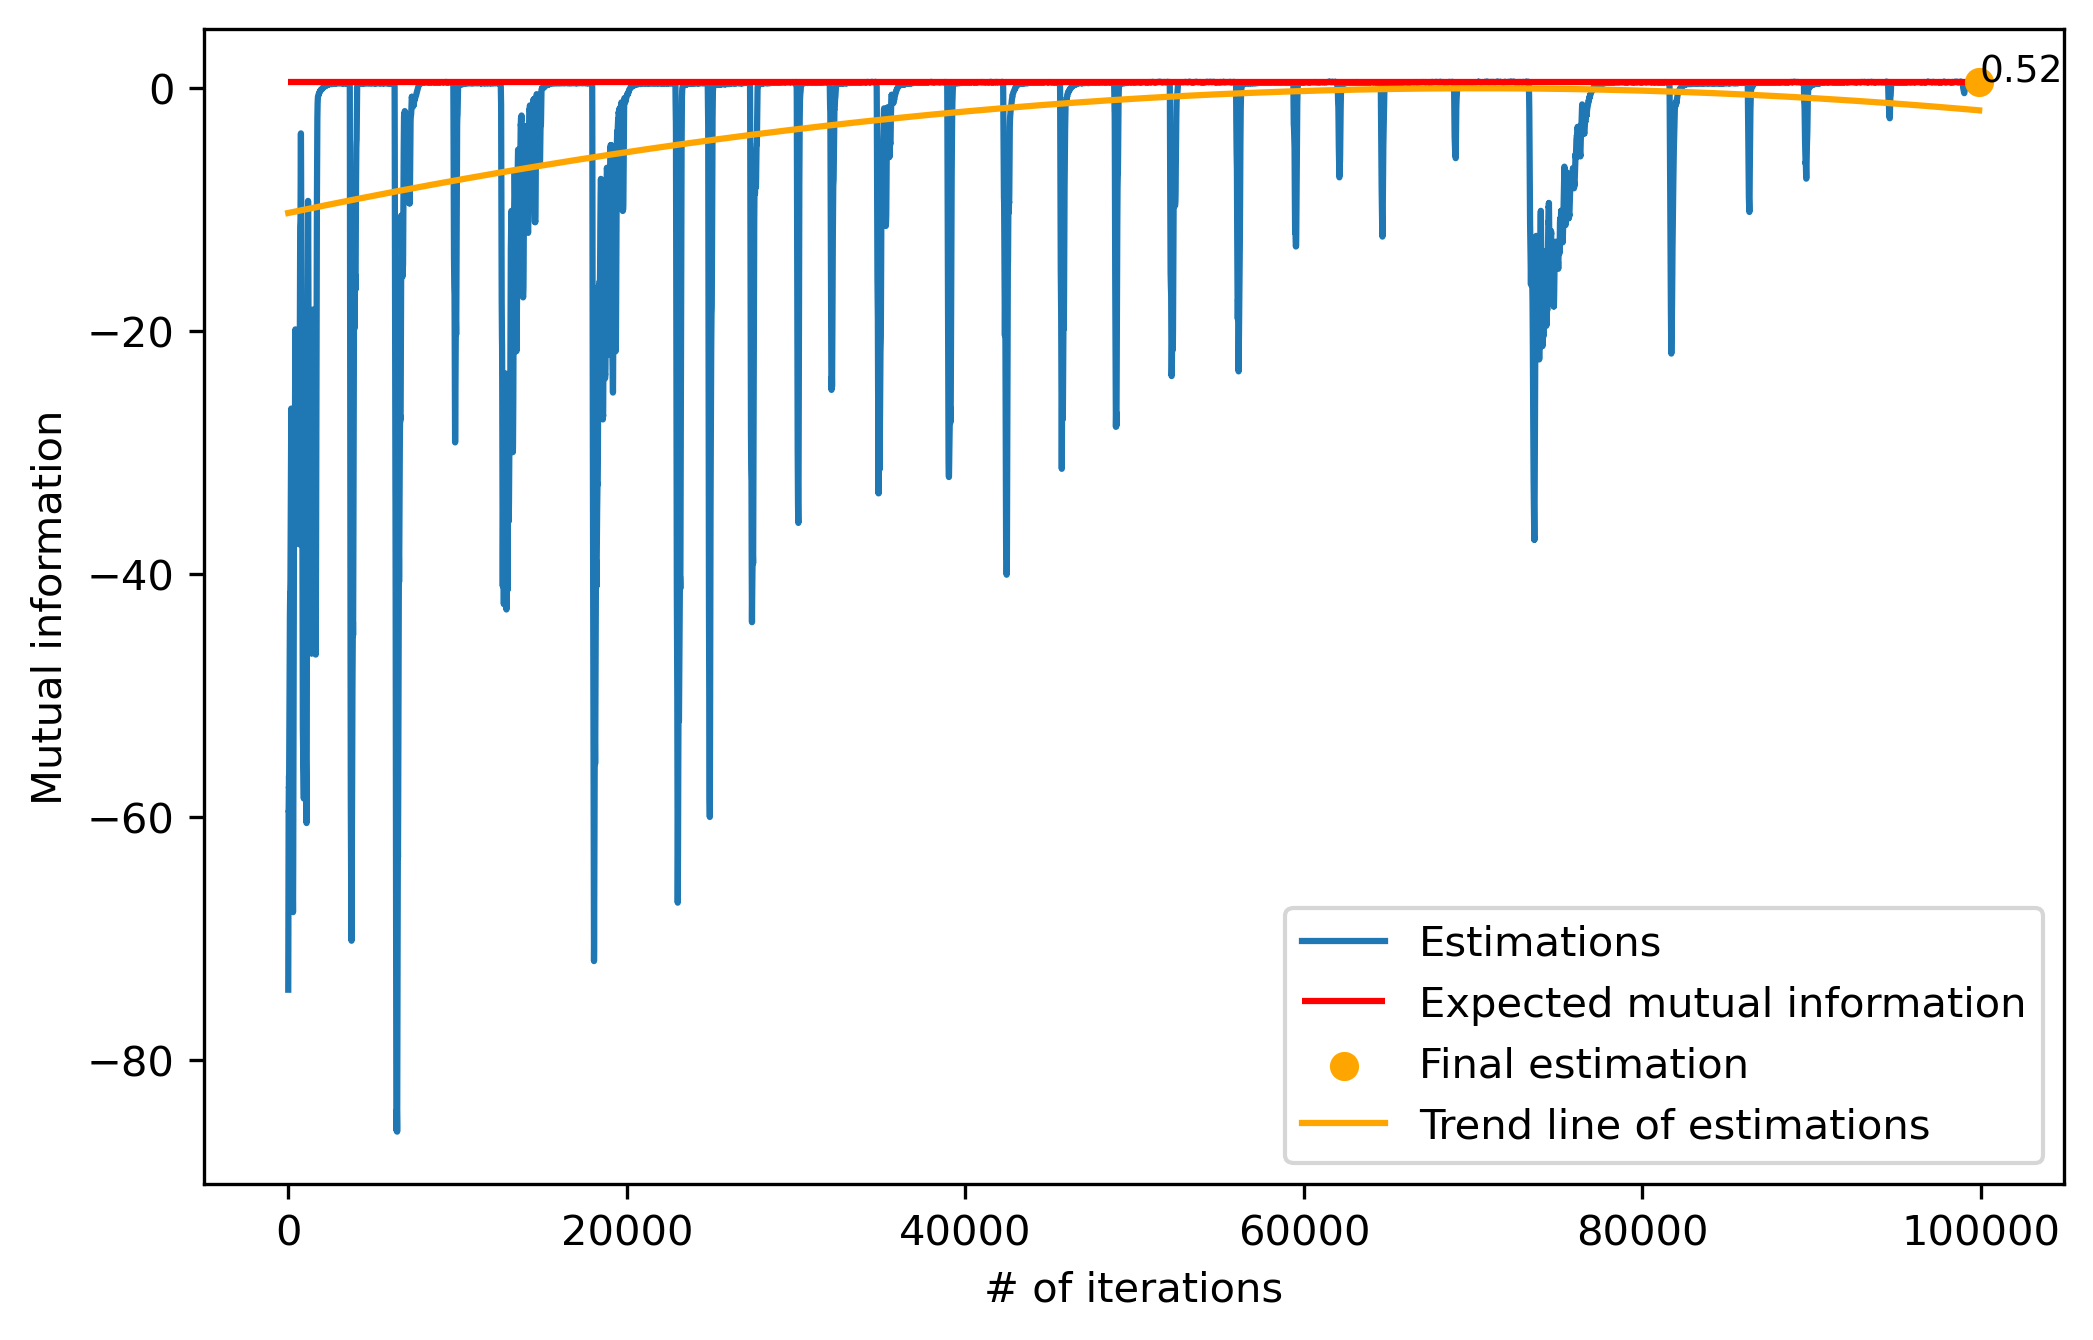

In [29]:
plot_data_scale_graphs(result_cor, 'mean_100_var_100_covar_80_scaled_2')